# Convolutional Neural Networks

In this notebook, you will be training Convolutional Neural Networks (CNNs) for image classification tasks. We will walk through the technicalities of building a CNN with TensorFlow's high-level Keras API as well as some practical tips for training CNNs and evaluating their performace.

If you are using Google Colab, make sure you are using a GPU-enabled runtime. Go to "Runtime" $\rightarrow$ "Change runtime type", then make sure "GPU" is selected for "Hardware accelerator".

## Setup

First we import the Python packages that we'll be using.

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.metrics import confusion_matrix, classification_report

# This is simply an alias for convenience
layers = tf.keras.layers


2021-09-12 17:42:46.440011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-12 17:42:46.440030: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We also define some utility functions that will be helpful. You don't need to look at these too closely, unless you are curious.

In [2]:
def get_attpc_class(label):
    """Gets the class name for a given label.
    
    Arguments:
        label (int): The integer target label.
        
    Returns:
        The name of the class that corresponds to the given label.
    """
    return ['proton', 'carbon', 'other'][label]

def load_attpc_data():
    """Loads in the AT-TPC data.
        
    Returns:
        A tuple of the form ((real_features, real_targets), (simulated_features, simulated_targets))
    """
    simulated_data_origin = 'https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/simulated-attpc-events.h5'
    real_data_origin = 'https://github.com/CompPhysics/MachineLearningMSU/raw/master/Day2_materials/data/real-attpc-events.h5'
    
    simulated_path = tf.keras.utils.get_file('simulated-attpc-data.h5', origin=simulated_data_origin)
    real_path = tf.keras.utils.get_file('real-attpc-data.h5', origin=real_data_origin)
    
    with h5py.File(simulated_path, 'r') as h5:
        simulated_features = h5['features'][:]
        simulated_targets = h5['targets'][:]
        
    with h5py.File(real_path, 'r') as h5:
        real_features = h5['features'][:]
        real_targets = h5['targets'][:]
    
    return (real_features, real_targets), (simulated_features, simulated_targets)

def plot_learning_curve(history):
    """Plots a learning curve from a training history.
    
    Arguments:
        history (dict): The training history returned by `model.fit()`.
        
    Returns:
        None.
    """
    plt.figure(figsize=(11, 6), dpi=100)
    plt.plot(history.history['loss'], 'o-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'o:', color='r', label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(0, len(history.history['loss'])), range(1, len(history.history['loss']) + 1))
    plt.show()
    
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix.
    
    Adapted from:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Arguments:
        y_true: Real class labels.
        y_pred: Predicted class labels.
        classes: List of class names.
        title: Title for the plot.
        cmap: Colormap to be used.
    
    Returns:
        None.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    plt.show()

## Classifying Handwritten Digits

We are going to start by training a model on the [MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/). MNIST is a classic dataset consisting of 70,000 images of handwritten digits (0 - 9). Our goal is to create a classifier that can identify the digit based on the image alone. This turns out to be a very easy problem (our CNN should have >99% accuracy), so it makes for a very good introduction to CNNs as we can easily verify that everything is working as expected.

### Data exploration and prepreprocessing

First, we need to load the data. TensorFlow makes this easy by including MNIST as one of the datasets that they provide easy access to through the `tf.keras.datasets` API. As a side note, many machine learning applications rely on a few standard datasets that are easily accessible through `tf.keras.datasets` and [TensorFlow Datasets](https://www.tensorflow.org/datasets). These are great resources that can often save lots of time.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

The data is conveniently already split in to a training set of 60,000 and a test set of 10,000. Now lets take a closer look at the training set.

In [4]:
print('Training Features:\n   Shape: {}\n   Type: {}\n'.format(x_train.shape, x_train.dtype))
print('Training Targets:\n   Shape: {}\n   Type: {}'.format(y_train.shape, y_train.dtype))

Training Features:
   Shape: (60000, 28, 28)
   Type: uint8

Training Targets:
   Shape: (60000,)
   Type: uint8


Each of the 60,000 training examples is a 28 x 28 grayscale image with pixel values in the range 0 - 255. We visualize the first 25 examples and their corresponding labels below.

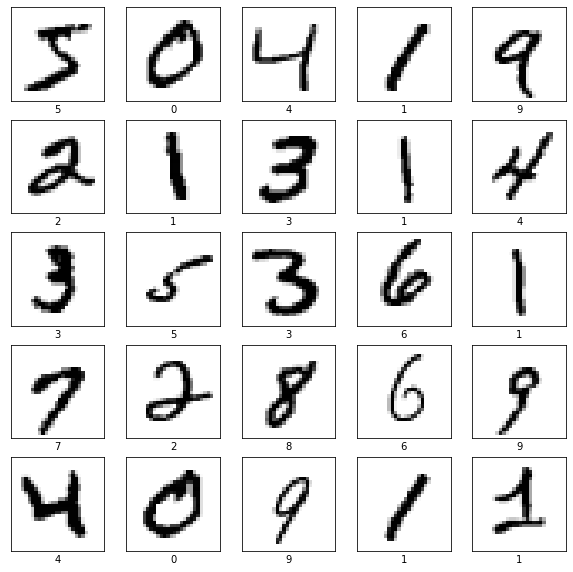

In [5]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
    
plt.show()

Now we must preprocess the data. While it doesn't actually make much a difference for the MNIST task, in general it is critical to perform some kind of normalization of your data before handing it off to a model. It can have a suprising large effect on a model's perforamce and make a model require less sensitive to hyperparameters. We will scale the pixel values to the range [-1, 1].

In [6]:
x_train = (x_train - 127.5) / 127.5
x_test = (x_test - 127.5) / 127.5

There is one final detail we need to take care of before proceeding. Images are generally three dimensional because there are three color channels. Because the MNIST data is grayscale, it is technically only two dimensional (one color channel), but the neural network is going to expect three dimensions regardless. So we just need to add an extra dimension to the data so that each example has the shape `(28, 28, 1)` and the network knows how to process the data.

In [7]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

print('Training data shape: {}'.format(x_train.shape))
print('Test data shape: {}'.format(x_test.shape))

Training data shape: (60000, 28, 28, 1)
Test data shape: (10000, 28, 28, 1)


### Build the model

Now we will construct our CNN with TensorFlow's Keras API. Most neural networks are composed of a sequence of feed-forward layers, meaning that each layer is only connected to the ones that come immediately before and after it. The `tf.keras.Sequential` model allows us to easily create such a network by simply defining what kinds of layers should be in the model. We don't have to concern ourselves with how to connect the layers together or how to define the training loop.

**In the cell below, construct a CNN with the following architecture:**
 1. Convolutional layer with 32 filters, a 4 x 4 kernel, and ReLU activation
 2. Max pooling layer with a 2 x 2 pool size
 3. Convolutional layer with 32 filters, a 4 x 4 kernel, and ReLU activation
 4. Max pooling layer with a 2 x 2 pool size
 5. Fully-connected layer with 128 units and ReLU activation
 6. Fully-connected layer with an output unit for each class and softmax activation
 
This architecture is a mini version of the novel architecture introduced by [Krizhevsky et al.](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf), which set the state-of-the-art on the ImageNet dataset and sparked the rise of CNNs.
 
Some tips:
 * Use `model.add(<layer>)` to add a new layer to the sequential model.
 * Use [`layers.Conv2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) for your convolutional layers.
 * Use [`layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) for your pooling layers.
 * Use [`layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) for your fully-connected layers.
 * Before adding the first fully-connected layer, the convolutional features must be flattened to a 1D vector. See [`layers.Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten).
 * The [`tf.nn`](https://www.tensorflow.org/api_docs/python/tf/nn) module provides access to several common activation functions.
 * The first layer in the network needs the keyword argument `input_shape` whose value is a tuple that gives the shape of a training example. This shape is already extracted from the data in the cell below, and just needs to be passed to the first layer.

In [8]:
# We extract the number of classes and the input shape from the data
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1:]

print(input_shape)

# Define a sequential model
model = tf.keras.Sequential()

# ADD LAYERS HERE
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(4,4), activation='relu', input_shape=input_shape)) # second hidden layer
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Conv2D(filters=32,kernel_size=(4,4), activation='relu')) 
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))
model.build(input_shape)
# This will print an overview of the network architecture
model.summary()

(28, 28, 1)


2021-09-12 17:42:51.353594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-12 17:42:51.353617: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-12 17:42:51.353637: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nichan): /proc/driver/nvidia/version does not exist
2021-09-12 17:42:51.353823: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

Now we can compile the model. We will use the [Adam](https://arxiv.org/pdf/1412.6980.pdf) optimizer (always a safe choice) and train the model to minimize the categorical crossentropy. We also have the model use classification accuracy as a measure of performance.

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

Now we can finally train the model. This model should converge relatively quickly, so we only need to train for about 5 epochs. We will use a batch size of 32, which is a common choice and generally works well. Training should only take about a minute on a GPU.

In [10]:
model.fit(x_train,
          y_train,
          batch_size=32,
          epochs=5);

2021-09-12 17:42:52.711026: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 188160000 exceeds 10% of free system memory.
2021-09-12 17:42:53.011118: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-12 17:42:53.051244: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1190400000 Hz


Epoch 1/5
1875/1875 [==============================] - 19s 9ms/step - loss: 0.1357 - accuracy: 0.9591
Epoch 2/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0459 - accuracy: 0.9859
Epoch 3/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0329 - accuracy: 0.9895
Epoch 4/5
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0244 - accuracy: 0.9923
Epoch 5/5
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0195 - accuracy: 0.9941


You should be able to see loss and accuracy improve as the model trains. If all goes well, training accuracy should be over 99% at the end.

### Evaluating the trained model

Now that our model has been trained, we can take a closer look at how it performs. The accuracy on the *training* data is very high, but of course that isn't always indicative of how a model will generalize to unseen data. Given enough representational power and training time, a neural network can simply learn to memorize the training data. We will evaluate our model on the held-out test data.

In [11]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print('Test accuracy: {:.04}'.format(test_accuracy))

Test accuracy: 0.9881


The test accuracy should be roughly the same as the training accuracy, which tells us that we have been successful! Because the model performs so well, there is not much need to analyze the performance further. We will do a more thorough evaluation in the next example though.

It is also worth mentioning that we didn't have to do any hyperparameter tuning in this example. This is an exception, and very rarely will a model perform so well right off the bat. So don't always expect to see great results on the first try. By the same token, **poor initial results are no indication of potential success.**

# Classifying AT-TPC $^{46}$Ar Data

Now we are going to look at some data that comes from the Argon 46 experiments in the AT-TPC. We will be working with 2D projections of reaction products and will train a CNN to try to classify the particle that was produced in the reaction.

This work is based on https://arxiv.org/abs/1810.10350

### Data exploration and preprocessing

First we load in the AT-TPC data. We will be working with two datasets: one contains real experimental data from the AT-TPC and the other contains simulated events that were created with [`pytpc`](https://github.com/ATTPC/pytpc).

In [12]:
(real_features, real_targets), (sim_features, sim_targets) = load_attpc_data()

In both datasets, each image is 128 x 128 and has pixel values in the range 0 - 255. There 50,000 simulated events, and 2,689 real events have been hand-labeled. Notice that this data has not yet been partitioned into training and testing sets.

In [13]:
print('Real Features:\n   Shape: {}\n   Type: {}\n'.format(real_features.shape, real_features.dtype))
print('Real Targets:\n   Shape: {}\n   Type: {}\n'.format(real_targets.shape, real_targets.dtype))
print('Simulated Features:\n   Shape: {}\n   Type: {}\n'.format(sim_features.shape, sim_features.dtype))
print('Simulated Targets:\n   Shape: {}\n   Type: {}'.format(sim_targets.shape, sim_targets.dtype))

Real Features:
   Shape: (2689, 128, 128)
   Type: uint8

Real Targets:
   Shape: (2689,)
   Type: uint8

Simulated Features:
   Shape: (50000, 128, 128)
   Type: uint8

Simulated Targets:
   Shape: (50000,)
   Type: uint8


If running this notebook on Google Colab, you will not be able to fit all 50,000 simulated events in RAM after they have been normalized. Run the cell below to use only 10,000.

In [14]:
sim_features = sim_features[:10000]
sim_targets = sim_targets[:10000]

#### Experimental data

We visualize the first 25 examples from the experimental dataset below. Events are classified as either "proton", "carbon", or "junk".

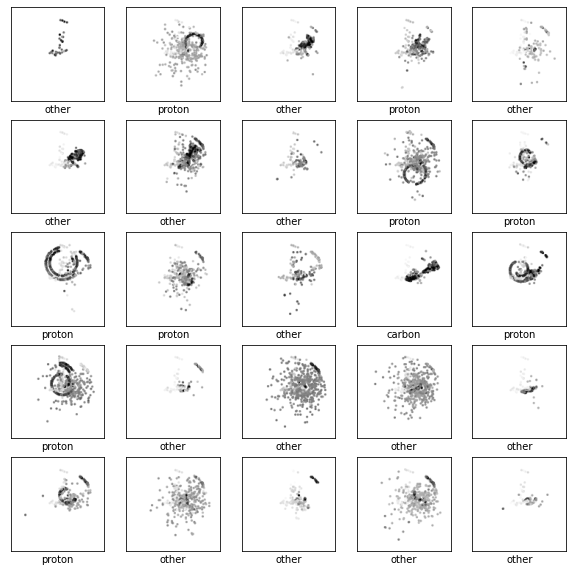

In [15]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(real_features[i], cmap='gray')
    plt.xlabel(get_attpc_class(real_targets[i]))
    
plt.show()

#### Simulated data

And now we visualize the first 25 examples from the simulated dataset. You'll notice that the noise in the simulated events looks very different from the noise in the real data. This is because there is some systematic structure to the noise in the experimental data, but we are unable to accuractly simulate that noise. This becomes a problem for us later.

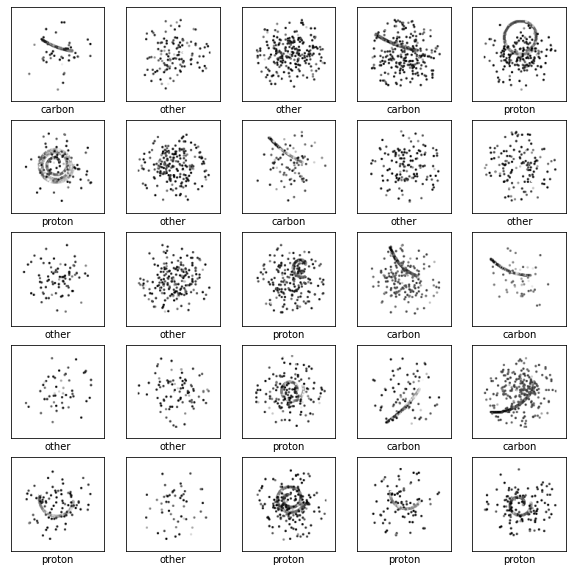

In [16]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sim_features[i], cmap='gray')
    plt.xlabel(get_attpc_class(sim_targets[i]))
    
plt.show()

Again, we need to preprocess the data. **In the cell below, normalize the data and add a channel dimension, as we did with the MNIST data.**

In [17]:
# NORMALIZE THE DATA
real_features = (real_features - 127.5) / 127.5
sim_features = (sim_features - 127.5) / 127.5

# ADD A CHANNEL DIMENSION
real_features = np.expand_dims(real_features, axis=3)
sim_features = np.expand_dims(sim_features, axis=3)

# Some checks to make sure the data has been correctly preprocessed
assert real_features.shape[1:] == (128, 128, 1), 'Real data has incorrect shape'
assert sim_features.shape[1:] == (128, 128, 1), 'Simulated data has incorrect shape'
assert real_features.min() >= -1 and real_features.max() <= 1, 'Real data is not in the range [-1, 1]'
assert sim_features.min() >= -1 and sim_features.max() <= 1, 'Simulated data is not in the range [-1, 1]'

### Build the model

In this example, we are going to do things a little differently. For the MNIST data, we constructed our own CNN and trained it from scratch. That worked really well for us because it was a small network, small dataset, and relatively easy problem. In practice, designing and training high-performing CNNs from scratch is time consuming and requires large-scale resources. So it is often best not to try to do this yourself. Luckily, companies like Google have already done the heavy lifting for us. TensorFlow provides access to several high-quality networks that have already been trained on datasets with millions of diverse images (such as [ImageNet](http://www.image-net.org)) as general computer-vision models. These complex networks have been trained to identify objects from up 1000 categories. This may not seem immediately useful, but it turns out that training these models on such a large scale forces the networks to learn to extract features are are broadly applicable to many computer vision tasks.

So rather than being a hero and training a CNN from scratch, we can instead use the pretrainined convolutional layers from one of these published models and add our own fully-connected classification layers on top. We keep the weights of the convolutional layers frozen, since we know they are already very good at feature extraction, and only update the weights of the top layers, which do the actual classification. This is much faster than training a CNN from scratch, and it can also result in better performance.

First, we are going to load in one of these pretrained models. In this example, we are going to use the [VGG16](https://arxiv.org/abs/1409.1556) architecture for image recognition (depicted below).

![VGG16 Architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

Before we actually load the model, there is one final caveat. The VGG network requires that its input images have three channels. Our images currently only have one, so we will add two more channels with the same values as the first. The new image dimensions should be 128 x 128 x 3.

In [18]:
real_features = np.repeat(real_features, 3, axis=3)
sim_features = np.repeat(sim_features, 3, axis=3)

input_shape = real_features.shape[1:]
print('Image dimensions: {}'.format(input_shape))

Image dimensions: (128, 128, 3)


In the cell below, we define a function that will load the VGG16 model with the parameter weights that were found by training it on [ImageNet](http://www.image-net.org). We also specify that we do not want to include the fully-connected top layers of the model, since those were not trained to classify our data. We will add our own fully connected layers instead. Unfortunately we can't use `vgg_model.add()` like before because it is not a `Sequential` model. The code below adds two fully-connected hidden layers and an output layer to the end of our VGG16 model using the [Functional API](https://www.tensorflow.org/guide/keras#functional_api). It's still a relatively high-level and intuitive API. Take a moment to read through it and understand it.

In [19]:
# Determine the number of class labels
num_classes = len(np.unique(real_targets))

def build_pretrained_vgg_model():
    """Constructs a CNN with a VGG16's convolutional base and two fully-connected hidden layers on top.
    The convolutional base is frozen (the weights can't be updated) and has weights from training on
    the ImageNet dataset.
    
    Returns:
        The model.
    """
    # This loads the VGG16 model from TensorFlow with ImageNet weights
    vgg_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # First we flatten out the features from the VGG16 model
    net = layers.Flatten()(vgg_model.output)

    # We create a new fully-connected layer that takes the flattened features as its input
    net = layers.Dense(512, activation=tf.nn.relu)(net)
    # And we add one more hidden layer
    net = layers.Dense(512, activation=tf.nn.relu)(net)

    # Then we add a final layer which is connected to the previous layer and
    # groups our images into one of the three classes
    output = layers.Dense(num_classes, activation=tf.nn.softmax)(net)

    # Finally, we create a new model whose input is that of the VGG16 model and whose output
    # is the final new layer we just created
    model = tf.keras.Model(inputs=vgg_model.input, outputs=output)
    
    # We loop through all layers except the last four and specify that we do not want 
    # their weights to be updated during training. Again, the weights of the convolutional
    # layers have already been trained for general-purpose feature extraction, and we only
    # want to update the fully-connected layers that we just added.
    for layer in model.layers[:-4]:
        layer.trainable = False
        
    return model

Now we can build and compile our model with the same setup as with the MNIST data. The `learning_rate` parameter simply determines how much the network weights will be updated on each gradient descent step; more on this later.

In [20]:
model = build_pretrained_vgg_model()

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.005), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

We are almost ready to train, but first we need to define our learning problem. With the MNIST data, you were provided with training and testing sets that came from the same data distribution. In practice, though, we are not always afforded this luxury. Aquiring large amounts of high-quality labeled data is often very challenging. In fact, the whole reason we want to train a classifier for the AT-TPC is so that humans don't need to hand-label the data! So while we could train the network on the real data, we are instead going to try *transfer learning*. This is when we train a model on one data distribution and try to transfer what it learns to a different distribution. In our case, we will train on the simulated data and save the real data for testing. Labeled simulated data is usually readily available in large quantities, so we want to try to use that to our advantage.

One final concept we will introduce here is a *validation set*. This is a third set of data that the network will not see during training, and we can use it to evaluate the performance of the model. Unlike the test set, though, we can use the feedback from the validation data to make adjustments that improve the model's performance. Then the final evaluation will be done with the test data.

Now we can train the model. The `validation_split=0.2` argument tells the program to set aside 20% of the traning data for validation. At the end of each epoch, the model will be evaluated on the validation set.

Note that training this model will take substantially longer than with the MNIST data. There are a couple of reasons for this. Obviously the network is much larger, and even though we are only training the top layers, there is still an expensive forward pass through the entire network. Also, our AT-TPC images are much larger than the MNIST data, in width, height, and number of channels. This should give you an idea for how these problems scale and why we like to start from networks that have already been trained on millions of images (rather than doing it ourselves).

We are going to start by using only 5,000 training examples so that the training time is managable at first (should be about 20 seconds per epoch on a GPU).

In [21]:
model.fit(sim_features[:5000],
          sim_targets[:5000],
          batch_size=32,
          epochs=3,
          validation_split=0.2);

2021-09-12 17:44:39.393882: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 786432000 exceeds 10% of free system memory.


Epoch 1/3


2021-09-12 17:44:44.482887: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.
2021-09-12 17:44:44.694759: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.


  1/125 [..............................] - ETA: 5:04 - loss: 1.1176 - accuracy: 0.3750

2021-09-12 17:44:45.930067: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 134217728 exceeds 10% of free system memory.


125/125 [==============================] - 243s 2s/step - loss: 1.0330 - accuracy: 0.7600 - val_loss: 0.2971 - val_accuracy: 0.8860
Epoch 2/3
125/125 [==============================] - 242s 2s/step - loss: 0.3029 - accuracy: 0.8792 - val_loss: 0.2596 - val_accuracy: 0.8980
Epoch 3/3
125/125 [==============================] - 226s 2s/step - loss: 0.2750 - accuracy: 0.8905 - val_loss: 0.2934 - val_accuracy: 0.8820


If all goes "right", you should see the model quickly gets stuck at about 33% training and validation accuracy. Essentially, the model is just making random guesses, since the simulated data is evenly distributed among the three classes. This is a perfect example of how things don't always work right off the bat. We usually need to do some hyperparameter tuning. Out of all the hyperparameters, learning rate is often the most important. If the learning rate is too low or too high, the gradient descent can get stuck at a local minimum or just bounce around.

Lets try again, but this time with a lower learning rate. **In the cell below, compile the model with an Adam optimizer with a learning rate of 0.001.**

In [22]:
# We have to remake the model in order to reset the weights.
# Otherwise, when we call `fit` again, we will be continuing training from where we left off before.
model = build_pretrained_vgg_model()

# ADD AN ADAM OPTIMIZER WITH A LEARNING RATE OF 0.001
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


model.fit(sim_features[:5000],
          sim_targets[:5000],
          batch_size=32,
          epochs=3,
          validation_split=0.2);

With just this small change, you should see a *huge* improvement in accuracy. The network actually learns something now! While this was a contrived example, it is very common for hyperparameters to greatly affect performance, so always make sure you try tuning your network before declaring failure.

#### Callbacks and saving trained networks

We are going to retrain the model for a little longer, but first we are going to introduce *callbacks*, which will allow us to periodically save network weights during training so that they can be reloaded at a later time. Callbacks are objects that you can pass to the model at training time which will perform certain tasks at the end of each epoch. In the cell below, we create a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback which will save the network parameters to files after each epoch.

In [ ]:
# This is the directory where model weights will be saved. Feel free to change it.
CHECKPOINT_DIR = './model-checkpoints/'

if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# The checkpoints will be saved with the corresponding epoch number in their filename
ckpt_path = os.path.join(CHECKPOINT_DIR, 'weights.epoch.{epoch:02d}')

# Setup checkpoint callback. We only save the weights, not the entire model
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(ckpt_path, save_weights_only=True)

Now we train the model again, this time for 10 epochs and pass our checkpoint callback to the `fit()` method.

In [ ]:
# Reset the model again
model = build_pretrained_vgg_model()
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# The `fit` method returns a dictionary containing metrics from the training.
# We will use that information later.
history = model.fit(sim_features[:5000],
                    sim_targets[:5000],
                    batch_size=32,
                    epochs=10,
                    validation_split=0.2,
                    callbacks=[ckpt_callback])

/data/Projects/MachineLearnECT/env/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
125/125 [==============================] - 237s 2s/step - loss: 0.5755 - accuracy: 0.7730 - val_loss: 0.3247 - val_accuracy: 0.8740
Epoch 2/10
125/125 [==============================] - 228s 2s/step - loss: 0.2815 - accuracy: 0.8852 - val_loss: 0.3232 - val_accuracy: 0.8580
Epoch 3/10
125/125 [==============================] - 227s 2s/step - loss: 0.2428 - accuracy: 0.9045 - val_loss: 0.3606 - val_accuracy: 0.8410
Epoch 4/10
125/125 [==============================] - 225s 2s/step - loss: 0.2582 - accuracy: 0.9025 - val_loss: 0.2886 - val_accuracy: 0.8860
Epoch 5/10
125/125 [==============================] - 231s 2s/step - loss: 0.2095 - accuracy: 0.9200 - val_loss: 0.3196 - val_accuracy: 0.8810
Epoch 6/10
125/125 [==============================] - 234s 2s/step - loss: 0.2316 - accuracy: 0.9125 - val_loss: 0.4048 - val_accuracy: 0.8400
Epoch 7/10
125/125 [==============================] - 234s 2s/step - loss: 0.1861 - accuracy: 0.9283 - val_loss: 0.2329 - val_accuracy: 0.9090

### Evaluating the trained model

Before evaluating the model on the real data, we should inspect its *learning curve*. Running the cell below will use the training history to generate a plot of the training loss and validation loss over time. The function call below will generate a learning curve for the model you just trained. Results will vary every time you run the previous cell, but you should see a point at which the training loss passes below the validation loss. This marks the onset of overfitting, which we want to avoid. There are many ways to try to remedy overfitting, such as using more training data, reducing network capacity, or using techniques like [dropout](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf?utm_content=buffer79b43&utm_medium=social&utm_source=twitter.com&utm_campaign=buffer). One technique that should always be used, though, is *early stopping*. Early stopping means that we stop training the model once overfitting begins, i.e. when the training and validation losses diverge.

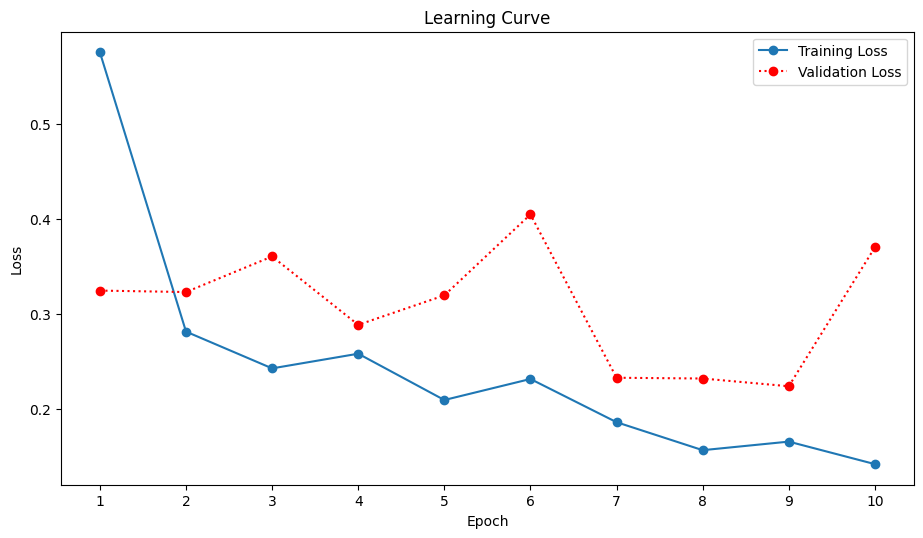

In [ ]:
plot_learning_curve(history)

Obviously we trained too long in this case because the two curves diverge (overfitting started at epoch 3 when I ran this, but will probably be anywhere between 2 and 6), so we will load the network weights that were saved at the point overfitting started before we evaluate the model on the test data. Loading saved weights is easy, and we do so below. Before executing the code, set `EARLY_STOPPING_EPOCH` to the appropriate value based on your learning curve above.

In [ ]:
EARLY_STOPPING_EPOCH = 3

assert EARLY_STOPPING_EPOCH > 0, 'You need to set an early stopping point!'

# Path the the checkpoint we want to load
es_ckpt_path = os.path.join(CHECKPOINT_DIR, 'weights.epoch.{:02d}'.format(EARLY_STOPPING_EPOCH))

# Load the weights from the desired checkpoint into the model
model.load_weights(es_ckpt_path);

Now we can finally see how our model does on the real AT-TPC data!

In [ ]:
test_loss, test_accuracy = model.evaluate(real_features, real_targets, verbose=0)

print('Test accuracy: {:.04}'.format(test_accuracy))

Test accuracy: 0.3284


The number you get could vary, but it shouldn't be anywhere near the validation accuracy. This is not too suprising though. Transfer learning is hard. The network has never seen any of the real data before, and since the simulated data is not entirely accurate, we can't expect the network to know everything about the real data. Supervised learning models are generally very good at interpolation, but not extrapolation.

That said, we can dig deeper than just looking at accuracy. In many cases, accuracy might not be what we are most interested in or it can even be misleading. In the case of the Argon 46 experiment, we are most interested in a model that can correctly identify proton events specifically. To get a better idea of how the model performs within each class, we will look at its *confusion matrix*.

First we get the model's predictions for all of the test data.

In [ ]:
# The model gives us a matrix with each example's softmax probabilities for each class
predicted_probabilities = model.predict(real_features)
# We reduce that to a single predicted class for each example by taking the
# class with the largest probability
predictions = np.argmax(predicted_probabilities, axis=1)

Now we can visualize the confusion matrix.

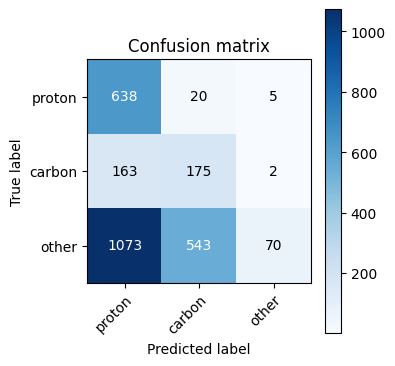

In [ ]:
# Get the names of each of the classes
class_names = [get_attpc_class(i) for i in range(num_classes)]

# This function (defined at the top) will plot the confution matrix.
# We give it the predictions and the real labels. The function relies
# on scikit-learn's convenient confusion matrix function.
plot_confusion_matrix(real_targets, predictions, class_names)

Your confusion matrix will vary, but it should give you a better idea of how your model performs within each class. From the matrix, we can extract a quantities:

 * **True Positives (TP):** the correctly predicted positive values, i.e. the examples which have true labels in a given class and were predicted to be in that class.
 * **True Negatives (TN):** the correctly predicted negative values, i.e. the examples which have true labels not in a given class and were predicted to not be in that class.
 * **False Positives (FP):** examples which were incorrectly assigned a positive value, i.e. the examples which have true labels not in a given class but were predicted to be in that class.
 * **False Negatives (FN):** examples which were incorrectly assigned a negative value, i.e. the examples which have true labels in a given class but were predicted to not be in that class.
 
So in the confusion matrix above, the number of true positives for each class are along the diagonal. Using these quantities, we can now define *precision*, *recall*, and *F1-score*.

$
\begin{align*}
    &\text{precision} = \dfrac{TP}{TP + FP} \\
    &\text{recall} = \dfrac{TP}{TP + FN} \\
    &\text{F1} = \dfrac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
\end{align*}
$

These three metrics are much more indicative of a classifier's true performace than accuracy. Intuitively, precision gives us the probability that the model is correct when it classifies something as a certain class. Recall tells us the percentage of examples from a certain class that were correctly classified.

We could calculate these by hand from the confusion matrix, but [Scikit-Learn](https://scikit-learn.org/) has the nice [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function which will do this for us. **In the cell below, replace `None` with a call to `classification_report`.**

In [ ]:
# ADD CALL TO CLASSIFICATION_REPORT HERE
report = classification_report(real_targets, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.34      0.96      0.50       663
           1       0.24      0.51      0.32       340
           2       0.91      0.04      0.08      1686

    accuracy                           0.33      2689
   macro avg       0.50      0.51      0.30      2689
weighted avg       0.68      0.33      0.21      2689



Since we only trained on a few thousand examples with limited hyperparameter tuning, we don't expect great results yet. I challenge you to try to improve these results!